In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
reit = screen_funds('Alternatives')
commodity = screen_funds('Commodities', min_assets=.2)
print(len(reit), len(commodity))
quote = Quote(reit + commodity, 60, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

12 21
from 2019-05-15 to 2019-07-12 - 33


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

24


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
PALL,36,2.329421,2.660474,0.860651,15.164162,2.616506
IAU,36,1.302763,2.016662,0.626322,9.193551,2.716592
BAR,36,1.296147,1.995984,0.629496,9.210523,2.700990
SGOL,36,1.294860,2.003945,0.626353,9.155664,2.692057
GLD,36,1.287573,1.983289,0.629203,9.102050,2.667662
GLTR,36,1.174420,1.655161,0.685575,7.681360,2.228544
PSLV,36,1.103408,1.881859,0.565253,6.603772,2.830190
XLRE,36,0.681851,2.097447,0.306167,3.943042,4.835459
DBA,36,0.583971,1.332814,0.408376,6.628783,2.544381


evicted DJP 0.853 -0.294
evicted RWO 0.779 -0.333
evicted COMT 0.427 -0.390
evicted PSLV 0.882 -0.399
evicted PALL 0.287 -0.023
evicted GLD 0.217 -0.326
retry backlogs ['BAR', 'GLTR', 'USRT', 'IAU', 'SGOL', 'VNQ', 'XLRE', 'IYR', 'SCHH', 'RWR', 'REET', 'SIVR', 'SLV', 'ICF', 'RWX'] at 0.905/-0.51 - 1.053
evicted SLV 0.905 -0.309
evicted ICF 0.517 -0.191
evicted SGOL 0.224 -0.329
retry backlogs ['USRT', 'IAU', 'BAR', 'SIVR', 'VNQ', 'RWR', 'REET', 'IYR', 'RWX', 'GLTR', 'XLRE', 'SCHH'] at 0.910/-0.52 - 1.053
evicted SIVR 0.900 -0.302
evicted RWR 0.582 -0.241
evicted BAR 0.229 -0.337
retry backlogs ['USRT', 'VNQ', 'IYR', 'IAU', 'GLTR', 'SCHH', 'XLRE', 'RWX', 'REET'] at 0.915/-0.53 - 1.053
evicted SCHH 0.583 -0.248
evicted IAU 0.221 -0.326
retry backlogs ['USRT', 'IYR', 'VNQ', 'GLTR', 'RWX', 'XLRE', 'REET'] at 0.920/-0.54 - 1.053
evicted XLRE 0.649 -0.136
retry backlogs ['IYR', 'USRT', 'VNQ', 'REET', 'RWX', 'REM'] at 0.925/-0.55 - 1.264
evicted REET 0.775 -0.297
evicted REM 0.521 -0.549
retry

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,36.0,0.669037,0.501988,-0.496912,0.437524,0.757155,0.974389,1.457057,1.253724,5.875324,1.011447
GLTR,36.0,1.174420,1.655161,-2.228544,0.345423,0.946794,2.370382,5.280986,0.685575,7.681360,2.228544
VNQI,36.0,0.539829,0.995143,-1.080244,-0.235906,0.522032,1.411845,2.348139,0.502588,4.382233,1.474619
DBA,36.0,0.583971,1.332814,-1.775143,-0.299314,0.184810,1.887473,3.650991,0.408376,6.628783,2.544381


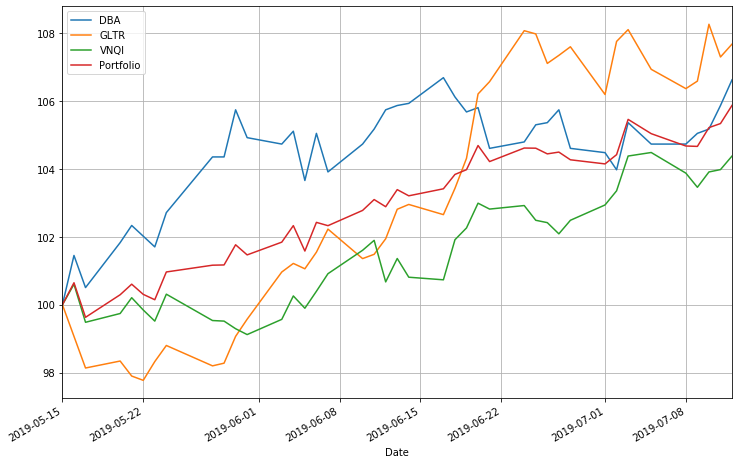

In [4]:
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio()
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio())
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)